# Introduction

This notebook is the third in the Makemore series. In part 2, we implemented a character-level language model using the MLP described in [Bengio et al. 2003](https://www.jmlr.org/papers/volume3/bengio03a/bengio03a.pdf). Our goal, is to graduate to a more complex neural networks such as an RNN with its variations (GRUs, LSTMs). But for this third part of the tutorial, Andrej decided to have us stick around MLPs for a bit longer. Why? **To get a deep and intuitive understanding of the activations in the neural network during training, and especially the gradients that are flowing backward, how they behave, and what they look like**. 

This understanding, Andrej said, is instrumental in understanding the development of architectures such as the RNN, and its variants. While Recurrent Neural Networks (RNNs) very expressive and a "general" approximator and can in theory implement all the algorithms, Andrej said that will see they are not easily optimizable using the gradient-based techniques we used so far. And the key reason why has to do with the activations, the gradients and how they behave during training. A lot of the variants since the original RNN, Andrej said, have tried to improve this situation.

That is the path Andrej would like us to take, and I am ready for it. Let's do this!

# Starter code

The code we set out to use in this part is very similar to what we used in `part-2`, but Andrej cleaned it up a little bit. So, I am copying his version of the code.

In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt # for making figures
%matplotlib inline

In [2]:
# read in all the words
words = open('names.txt', 'r').read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [3]:
len(words)

32033

In [4]:
# build the vocabulary of characters and mappings to/from integers
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
vocab_size = len(itos)
print(itos)
print(vocab_size)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}
27


In [5]:
# build the dataset
block_size = 3 # context length: how many characters do we take to predict the next one?

def build_dataset(words):
    
    X, Y = [], []
    for w in words:
        context = [0] * block_size
        
        for ch in w + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix] # crop and append

    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

# Split into train, dev, and test sets
Xtr,  Ytr  = build_dataset(words[:n1])     # 80%
Xdev, Ydev = build_dataset(words[n1:n2])   # 10%
Xte,  Yte  = build_dataset(words[n2:])     # 10%

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [6]:
# MLP revisited
n_embed = 10 # the dimensionality of the character embeding vectors
n_hidden = 200 # the number of neurons in the hidden layer of the MLP

g = torch.Generator().manual_seed(2147483647) # for reproducibility
C = torch.randn((vocab_size, n_embed),              generator=g)
W1 = torch.randn((n_embed * block_size, n_hidden),  generator=g)
b1 = torch.randn(n_hidden,                          generator=g)
W2 = torch.randn((n_hidden, vocab_size),            generator=g)
b2 = torch.randn(vocab_size,                        generator=g)

parameters = [C, W1, b1, W2, b2]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
    p.requires_grad = True

11897


In [7]:
# Same optimization as last time
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):
    
    # minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix] # batch X, Y
    
    # forward pass
    emb = C[Xb] # embed the characters into vectors
    embcat = emb.view(emb.shape[0], -1) # concatenate the vectors
    hpreact = embcat @ W1 + b1 # hidden layer pre-activation
    h = torch.tanh(hpreact) # hidden layer
    logits = h @ W2 + b2 # output layer
    loss = F.cross_entropy(logits, Yb) # loss function
    
    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()
    
    # update
    lr = 0.1 if i < 100000 else 0.01 # step learning rate decay
    for p in parameters:
        p.data += -lr * p.grad
        
    # track stats
    if i % 10000 == 0: # print every once in a white (multiple)
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())

      0/ 200000: 27.8817
  10000/ 200000: 2.8263
  20000/ 200000: 2.5130
  30000/ 200000: 2.8010
  40000/ 200000: 2.0541
  50000/ 200000: 2.6152
  60000/ 200000: 2.3549
  70000/ 200000: 2.0835
  80000/ 200000: 2.2652
  90000/ 200000: 2.2635
 100000/ 200000: 2.0810
 110000/ 200000: 2.3367
 120000/ 200000: 1.9650
 130000/ 200000: 2.4398
 140000/ 200000: 2.1524
 150000/ 200000: 2.1201
 160000/ 200000: 2.0399
 170000/ 200000: 1.8172
 180000/ 200000: 2.0771
 190000/ 200000: 1.7632


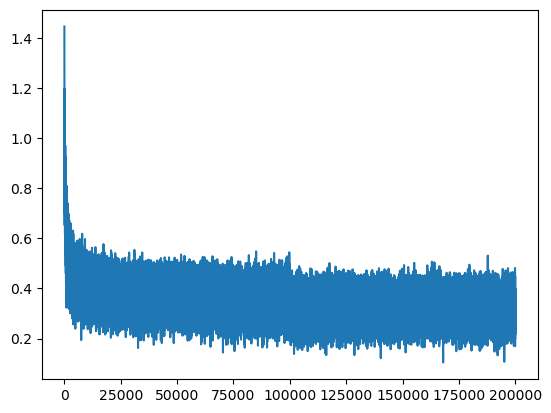

In [8]:
plt.plot(lossi)

In [9]:
@torch.no_grad() # this decorator disables gradient tracking
def split_loss(split):
    x,y = {
        'train': (Xtr, Ytr),
        'val': (Xdev, Ydev),
        'test': (Xte, Yte),
    }[split]
    emb = C[x] # (N, block_size, n_embd)
    embcat = emb.view(emb.shape[0], -1) # concat into (N, block_size * n_embd)
    h = torch.tanh(embcat @ W1 + b1) # (N, n_hidden)
    logits = h @ W2 + b2 # (N, vocab_size)
    loss = F.cross_entropy(logits, y)
    print(split, loss.item())
    
split_loss('train')
split_loss('val')

train 2.1261181831359863
val 2.1693320274353027


In [10]:
# sample from the model
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):
    
    out = []
    context = [0] * block_size # initialize with "..."
    while True:
        # forward pass the neural net
        emb = C[torch.tensor([context])] # (1, block_size, n_embd)
        h = torch.tanh(emb.view(1, -1) @ W1 + b1)
        logits = h @ W2 + b2
        probs = F.softmax(logits, dim=1)
        # sample from the distribution
        ix = torch.multinomial(probs, num_samples=1, generator=g).item()
        # shift context window and incorporates the previously made prediction, "ix"
        context = context[1:] + [ix]
        out.append(ix)
        # if we sample the special '.' token, break
        if ix == 0:
            break
    
    print(''.join(itos[i] for i in out)) # decode and print the generated word

carlah.
amorie.
khi.
myli.
taty.
salayson.
mahnen.
den.
art.
kaeli.
nellara.
chaiir.
kaleigh.
ham.
jorn.
quint.
salin.
alianni.
wazthoniearynix.
kaelissuli.


# Fixing the initial loss

With our starting code written, the first thing Andrej brought up was the **initialization**. Our network, he said, is improperly initialized for several reasons. While looking at the following:

```
 0/ 200000: 27.8817
  10000/ 200000: 2.8263
  20000/ 200000: 2.5130
  30000/ 200000: 2.8010
  40000/ 200000: 2.0541
  50000/ 200000: 2.6152
  60000/ 200000: 2.3549
  70000/ 200000: 2.0835
  80000/ 200000: 2.2652
  90000/ 200000: 2.2635
 100000/ 200000: 2.0810
 110000/ 200000: 2.3367
 120000/ 200000: 1.9650
 130000/ 200000: 2.4398
 140000/ 200000: 2.1524
 150000/ 200000: 2.1201
 160000/ 200000: 2.0399
 170000/ 200000: 1.8172
 180000/ 200000: 2.0771
 190000/ 200000: 1.7632
```
On the $0^{th}$ iteration, a loss of $27.8$ was recorded. This loss rapidly falls to $2$, and then later goes to $1$. This rapid fall, Andrej pointed out, reveals that the weights' initialization is messed up. In training of neural nets, he continued, it is almost always the case to have an idea of what loss to expect at initialization, and that depends on the loss function and the problem setup.

In our case, Andrej did not expect $27$ as a loss, but rather smaller number that we'll soon calculate together.

At initialization, Andrej said, there are $27$ possible characters that could come next for any training example. At such an early stage, however, we have no reason to believe that one character is more likely than another. As a result, we'd expect the probability distribution coming out of the network to be uniform, effectively assigning the same probability to the $27$ characters. In other words, we'd expect that the probabilities be equal or close to $\frac{1}{27}$, at initialization. And the loss should be:

In [11]:
-torch.tensor(1/27.0).log()

tensor(3.2958)

This is the loss value to be expected at initialization, $3.2958$. It is much lower than the $27$ we got earlier. What is happening is that at initialization the neural net produces probability distributions that are all "messed up" (the term Andrej used). The network assigns a very high probability to certain characters, while assigning a very low probability to others. The network is very confidently wrong. Thus resulting a very high loss.

To further illustrate this, Andrej proposed to consider 4-dimensional example of the issue.

In [12]:
# 4-dimensional example of the issue
logits = torch.tensor([0.0, 0.0, 0.0, 0.0])
#logits = torch.randn(4) # randomly pick 4 logits out of a normal distribution
#logits = torch.randn(4) # randomly pick 4 extreme logits
probs = torch.softmax(logits, dim=0)
loss = -probs[2].log()
probs, loss

(tensor([0.2500, 0.2500, 0.2500, 0.2500]), tensor(1.3863))

In the scenario where we have only 4 characters, so four possible predictions, and _we have logits coming out of the neural network that are very close to zero_. Taking the softmax results in a uniform (i.e. difused ) probability distribution. If the correct label is, say $2$, then the loss is given by `-probs[2].log()` which is equal to $1.3863$. It is low, right?

So, if by "chance", at initialization the network assigns a high probability to the correct label, then the resulting loss will be low. Conversely, if the network assigns a high probability to the wrong label, then the resulting loss will be high. To illustrate this, Andrej randomly picked four logits out of a normal distribution (so somewhat close to zero) and the resulting was low... when he picked some extreme logit values, the resulting loss was much higher. Try playing around with the values in the `logits` tensor and see how it affects the loss.

All of that to say: **We want the network to be output a somewhat uniform probability distribution at initialization. In other words, we want the network to produce somewhat equal logits (zeroes) at initialization**.

The reason why we acheive a high loss on the first iteration like we saw is because the logits the network produced are extreme, and the network assigns a high probability to the wrong label. So, the million dollar question is:

> How do we initialized the network weights such that logits come out closer to zero?

First, the logits of the network are calculated by matrix-multiplying the hidden state `h` with `w2`, and then adding the bias `b2`. `b2` is initialized with random numbers, but because we want to be close to zero a set of random biases is undesirable. So, we scale `b2` with zero instead, to ensure that initialization the tensor contains only zeroes.

Second, we want to make `w2` as well. So we also scale down the matrix by `0.01`. Andrej said it is undesirable to initialize weight matrices to zero, and said he will show us why a little later.

With all those changes the new neural network looks like this:

In [15]:
# MLP revisited
n_embed = 10 # the dimensionality of the character embeding vectors
n_hidden = 200 # the number of neurons in the hidden layer of the MLP

g = torch.Generator().manual_seed(2147483647) # for reproducibility
C = torch.randn((vocab_size, n_embed),              generator=g)
W1 = torch.randn((n_embed * block_size, n_hidden),  generator=g)
b1 = torch.randn(n_hidden,                          generator=g)
W2 = torch.randn((n_hidden, vocab_size),            generator=g) * 0.01 # NOT ZERO
b2 = torch.randn(vocab_size,                        generator=g) * 0 # ZERO

parameters = [C, W1, b1, W2, b2]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
    p.requires_grad = True

11897


In [16]:
# Same optimization as last time
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):
    
    # minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix] # batch X, Y
    
    # forward pass
    emb = C[Xb] # embed the characters into vectors
    embcat = emb.view(emb.shape[0], -1) # concatenate the vectors
    hpreact = embcat @ W1 + b1 # hidden layer pre-activation
    h = torch.tanh(hpreact) # hidden layer
    logits = h @ W2 + b2 # output layer
    loss = F.cross_entropy(logits, Yb) # loss function
    
    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()
    
    # update
    lr = 0.1 if i < 100000 else 0.01 # step learning rate decay
    for p in parameters:
        p.data += -lr * p.grad
        
    # track stats
    if i % 10000 == 0: # print every once in a white (multiple)
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())

      0/ 200000: 3.3221
  10000/ 200000: 2.1900
  20000/ 200000: 2.4196
  30000/ 200000: 2.6067
  40000/ 200000: 2.0601
  50000/ 200000: 2.4988
  60000/ 200000: 2.3902
  70000/ 200000: 2.1344
  80000/ 200000: 2.3369
  90000/ 200000: 2.1299
 100000/ 200000: 1.8329
 110000/ 200000: 2.2053
 120000/ 200000: 1.8540
 130000/ 200000: 2.4566
 140000/ 200000: 2.1879
 150000/ 200000: 2.1118
 160000/ 200000: 1.8956
 170000/ 200000: 1.8645
 180000/ 200000: 2.0326
 190000/ 200000: 1.8417


Right of the bat, we can see that the loss at the $0^{th}$ is much closer to our calculation $\frac{1}{27}$. We get a loss of $3.3221$, which is a better starting point. Similarly, the loss plot, no longer has this "hockey" shape appearance. 

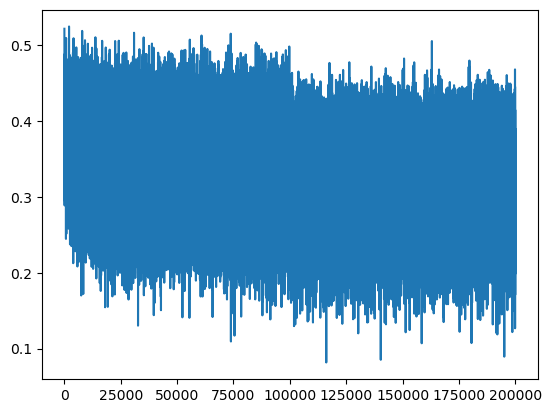

In [17]:
plt.plot(lossi)

When the loss had that "hockey" shape appearance, Andrej said, the optimization first **squashed the logits near ZERO**, then **re-arrange the logits** towards right predictions. In other words, during optimization the weights are updated such that the network start producing logits that are closer to zero. And like we saw earlier, this is desirable.

So, by initiliazing the `b2` and `W2` to zero, and something close to zeros, we skip the easy gains observed at the beginning of training like before. Instead, we are getting the hard gains of the actual training of the neural net. For this reason, we no longer see this "hockey" stick appearance, but rather something that is decreasing veryyy slowly.

Now, two good things are now happening according to Andrej:

1. Loss at initialization is close to what we expect.

2. The loss curve no longer looks like a hockey stick

**NOTE: This is something to look out for, for ANY neural network we might train**

# Fixing the saturated `tanh`

Fixing the initial loss, and the loss curve was the first problem. Now, we are looking at the second problem. (TO BE CONTINUED)